# This notebook is meant to train a Neural Network model using keras

### Parameters
- Optimizer - Adam
- Loss function - Categorical Crossentropy
- Input layer - 4 values
- Output layer - 3 categories
- Hidden layer - 1 layer with 6 nodes

In [13]:
# Importing necessery libraries
%matplotlib inline
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import keras
import matplotlib.pyplot as plt

In [28]:
# Reading out data
df = pd.read_csv('../data/file20000.csv')
df.head()

,Unnamed: 0,0,1,2,3,4
0,0,1.0,8,8,8,0
1,1,0.0,8,8,8,1
2,2,0.0,8,8,6,1
3,3,0.0,8,8,5,1
4,4,0.0,8,6,4,1


In [29]:
# Removing redundant column Unnamed: 0
df = df.drop('Unnamed: 0', 1)

#### From the table above we see that the column ```Unnamed: 0``` is redundant, as it shows the count of rows which can be found in pandas table whenever printing a dataframe.

#### Also the headers of columns are meaningless. They should be renamed to the following:
- First column - My_position,
- Second column - Left_line,
- Third column - Middle_line,
- Fourth column - Right_line,
- Fifth column - Action

In [30]:
# Renaming headers of columns
df.rename(columns={'0': 'My_position', '1': 'Left_line', '2': 'Mid_line', '3': 'Right_line', '4': 'Action'}, inplace=True)
df.head()

,My_position,Left_line,Mid_line,Right_line,Action
0,1.0,8,8,8,0
1,0.0,8,8,8,1
2,0.0,8,8,6,1
3,0.0,8,8,5,1
4,0.0,8,6,4,1


In [31]:
# Checking data insights
df.describe()

,My_position,Left_line,Mid_line,Right_line,Action
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.972250,3.683650,3.681500,3.665100,0.999950
std,0.783269,2.975805,2.946573,2.969223,0.450067
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,3.000000,3.000000,3.000000,1.000000
75%,2.000000,6.500000,6.000000,6.000000,1.000000
max,2.000000,8.000000,8.000000,8.000000,2.000000


#### From the table above we can assume the following:
#### ```Mean``` values of all columns are acceptable
- For <b>My_position</b> and <b>Action</b> columns we have values from [ 0 to 2 ], the mean is expected to be equal to 1
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> comuns we have values form [ 0 to 8 ], the mean is expected to be equal to 4
#### ```Std``` values of all columns are acceptable


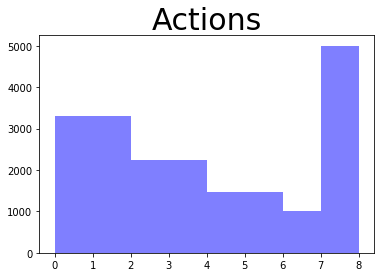

In [41]:
plt.title('Actions',fontsize=30)
# Left - 0, Stay - 1, Right -2
amount_of_actions = 8
n, bins, patches = plt.hist(df['Left_line'], amount_of_actions, facecolor='blue', alpha=0.5)
plt.show()

In [42]:
df.Mid_line.value_counts()

8    4872
0    3377
1    2967
3    2431
2    2273
5    1600
4    1516
6     964
Name: Mid_line, dtype: int64

In [9]:
for i in range(len(df['Action'])):
    if df['Action'][i] == 1:
        a = random.randint(0,9)
        if a > 0:
            df['Action'][i] = None

In [10]:
df.head()

,MyPosition,leftLine,MidLine,RightLine,Action
0,1,6,6,6,0.0
1,0,6,6,6,1.0
2,0,5,6,6,2.0
3,1,4,6,6,NaN
4,1,3,6,5,NaN


In [12]:
newDF = df.dropna()

In [ ]:
# newDF['Action'] = newDF['Action'].astype(int)

In [13]:
df.Action.value_counts()

2.0    867
0.0    866
1.0    816
Name: Action, dtype: int64

In [14]:
inputData = newDF.drop('Action',1)
inputData.head()

,MyPosition,leftLine,MidLine,RightLine
0,1,6,6,6
1,0,6,6,6
2,0,5,6,6
8,1,6,6,1
13,0,6,6,0


In [15]:
outputData = newDF['Action']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(inputData, outputData, test_size=0.20, random_state=4)

In [17]:
y_train = keras.utils.to_categorical(y_train, 3)

In [18]:
y_test = keras.utils.to_categorical(y_test, 3)

In [19]:
# define the keras model
model = Sequential()
model.add(Dense(6, input_shape=(4, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [21]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





2039/2039 [==============================] - 3s 1ms/step - loss: 1.7027 - acc: 0.3953
Epoch 2/100
2039/2039 [==============================] - 1s 328us/step - loss: 1.0448 - acc: 0.5282
Epoch 3/100
2039/2039 [==============================] - 1s 507us/step - loss: 0.8552 - acc: 0.5964
Epoch 4/100
2039/2039 [==============================] - 1s 481us/step - loss: 0.7494 - acc: 0.6699
Epoch 5/100
2039/2039 [==============================] - 1s 480us/step - loss: 0.6966 - acc: 0.6846
Epoch 6/100
2039/2039 [==============================] - 1s 346us/step - loss: 0.6562 - acc: 0.7273
Epoch 7/100
2039/2039 [==============================] - 1s 342us/step - loss: 0.6130 - acc: 0.7563
Epoch 8/100
2039/2039 [==============================] - 1s 299us/step - loss: 0.5916 - acc: 0.7592
Epoch 9/100
2039/2039 [==============================] - 1s 282us/step - loss: 0.5538 - acc: 0.7783


In [22]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

510/510 [==============================] - 0s 488us/step
Accuracy: 100.00


In [24]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
del model  

# Returns a compiled model identical to the previous one
model = load_model('my_model.h5')

In [25]:
predictions = model.predict_classes(X_test)
predictions[0:20]

array([0, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 2])

In [28]:
X_test

,MyPosition,leftLine,MidLine,RightLine
658,0,1,6,5
1438,2,1,6,3
1142,2,1,6,3
1794,2,1,6,3
1704,0,1,6,5
...,...,...,...,...
1697,1,0,6,4
1224,2,3,6,1
398,1,1,3,6
1298,1,1,3,6


In [29]:
import numpy as np

In [ ]:
X_test.head()

In [32]:
inputData = np.array([[2,1,6,3]])

In [33]:
model.predict_classes(inputData)

array([0])

In [ ]:
X_test.iloc[0]

In [ ]:
bla = np.array(X_test.iloc[0:])
bla

In [ ]:
model.predict_classes(bla)